<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/multi_class_U_Net_Model_(11_march_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# multi-class u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 67.7 MB/s eta 0:00:00


In [4]:
import rasterio

In [5]:
from sklearn.model_selection import train_test_split
import shutil

OneYear data loading

In [6]:
directory_path = "/content/drive/MyDrive/data/working_dir_1year/train/images"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 199 files in /content/drive/MyDrive/data/working_dir_1year/train/images.


In [7]:
directory_path = "/content/drive/MyDrive/data/working_dir_1year/train/GT"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 199 files in /content/drive/MyDrive/data/working_dir_1year/train/GT.


In [8]:
# Ensure the lists are sorted so that images and labels correspond to each other
planet_images_ONE = sorted(glob.glob(f"/content/drive/MyDrive/data/working_dir_1year/train/images/*.tif"))
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/data/working_dir_1year/train/GT/*.tif"))

# Split the file paths into training and testing sets (80% train, 20% test)
train_images_paths, validation_images_paths, train_labels_paths, validation_labels_paths = train_test_split(
    planet_images_ONE, planet_labels, test_size=0.2, random_state=42)

In [9]:
#  1 minute
destination = '/content/validation_labels'
os.makedirs(destination, exist_ok=True)
for file in validation_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/174_multi_wl.tif to /content/validation_labels/174_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1489_multi_wl.tif to /content/validation_labels/1489_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/288_multi_wl.tif to /content/validation_labels/288_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/831_multi_wl.tif to /content/validation_labels/831_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1645_multi_wl.tif to /content/validation_labels/1645_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/809_multi_wl.tif to /content/validation_labels/809_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1596_multi_wl.tif to /content/validation_labels/1596_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1595_multi_wl.tif to /content/validation_labels/15

In [10]:
# 40 files
directory_path = "/content/validation_labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 40 files in /content/validation_labels.


In [11]:
#  9 minute
destination = '/content/train_labels'
os.makedirs(destination, exist_ok=True)
for file in train_labels_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/845_multi_wl.tif to /content/train_labels/845_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1536_multi_wl.tif to /content/train_labels/1536_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1507_multi_wl.tif to /content/train_labels/1507_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/778_multi_wl.tif to /content/train_labels/778_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/777_multi_wl.tif to /content/train_labels/777_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1520_multi_wl.tif to /content/train_labels/1520_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/1498_multi_wl.tif to /content/train_labels/1498_multi_wl.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/GT/821_multi_wl.tif to /content/train_labels/821_multi_wl.tif
Copied /content/drive/My

In [12]:
# 159 files
directory_path = "/content/train_labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 159 files in /content/train_labels.


In [13]:
#  2 minute
destination = '/content/validation_images_ONE'
os.makedirs(destination, exist_ok=True)
for file in validation_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_1year/train/images/174_1year.tif to /content/validation_images_ONE/174_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1489_1year.tif to /content/validation_images_ONE/1489_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/288_1year.tif to /content/validation_images_ONE/288_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/831_1year.tif to /content/validation_images_ONE/831_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1645_1year.tif to /content/validation_images_ONE/1645_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/809_1year.tif to /content/validation_images_ONE/809_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1596_1year.tif to /content/validation_images_ONE/1596_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1595_1year.tif to /content/valid

In [14]:
# 40 files
directory_path = "/content/validation_images_ONE"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 40 files in /content/validation_images_ONE.


In [15]:
#  12 minute
destination = '/content/train_images_ONE'
os.makedirs(destination, exist_ok=True)
for file in train_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_1year/train/images/845_1year.tif to /content/train_images_ONE/845_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1536_1year.tif to /content/train_images_ONE/1536_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1507_1year.tif to /content/train_images_ONE/1507_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/778_1year.tif to /content/train_images_ONE/778_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/777_1year.tif to /content/train_images_ONE/777_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1520_1year.tif to /content/train_images_ONE/1520_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/1498_1year.tif to /content/train_images_ONE/1498_1year.tif
Copied /content/drive/MyDrive/data/working_dir_1year/train/images/821_1year.tif to /content/train_images_ONE/821_1year.tif
Copied /

In [16]:
# 159 files
directory_path = "/content/train_images_ONE"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 159 files in /content/train_images_ONE.


In [17]:
train_images_ONE = sorted(glob.glob(f"/content/train_images_ONE/*.tif"))
train_labels = sorted(glob.glob(f"/content/train_labels/*.tif"))

validation_images_ONE = sorted(glob.glob(f"/content/validation_images_ONE/*.tif"))
validation_labels= sorted(glob.glob(f"/content/validation_labels/*.tif"))

In [18]:
print(f"there are {len(train_images_ONE)} images for training")
print(f"there are {len(train_labels)} labels for training")
print(f"there are {len(validation_images_ONE)} images for validation")
print(f"there are {len(validation_labels)} labels for validation")

there are 159 images for training
there are 159 labels for training
there are 40 images for validation
there are 40 labels for validation


TwoYear data loading

In [67]:
directory_path = "/content/drive/MyDrive/data/working_dir_2year/train/images"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 199 files in /content/drive/MyDrive/data/working_dir_2year/train/images.


In [68]:
# Ensure the lists are sorted so that images and labels correspond to each other
planet_images_TWO = sorted(glob.glob(f"/content/drive/MyDrive/data/working_dir_2year/train/images/*.tif"))
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/data/working_dir_1year/train/GT/*.tif"))

# Split the file paths into training and testing sets (85% train, 15% test)
train_images_paths, validation_images_paths, train_labels_paths, validation_labels_paths = train_test_split(
    planet_images_TWO, planet_labels, test_size=0.20, random_state=42)

In [69]:
destination = '/content/validation_images_TWO'
os.makedirs(destination, exist_ok=True)
for file in validation_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_2year/train/images/174_2year.tif to /content/validation_images_TWO/174_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1489_2year.tif to /content/validation_images_TWO/1489_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/288_2year.tif to /content/validation_images_TWO/288_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/831_2year.tif to /content/validation_images_TWO/831_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1645_2year.tif to /content/validation_images_TWO/1645_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/809_2year.tif to /content/validation_images_TWO/809_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1596_2year.tif to /content/validation_images_TWO/1596_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1595_2year.tif to /content/valid

In [72]:
destination = '/content/train_images_TWO'
os.makedirs(destination, exist_ok=True)
for file in train_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_2year/train/images/845_2year.tif to /content/train_images_TWO/845_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1536_2year.tif to /content/train_images_TWO/1536_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1507_2year.tif to /content/train_images_TWO/1507_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/778_2year.tif to /content/train_images_TWO/778_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/777_2year.tif to /content/train_images_TWO/777_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1520_2year.tif to /content/train_images_TWO/1520_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/1498_2year.tif to /content/train_images_TWO/1498_2year.tif
Copied /content/drive/MyDrive/data/working_dir_2year/train/images/821_2year.tif to /content/train_images_TWO/821_2year.tif
Copied /

In [73]:
train_images_TWO = sorted(glob.glob(f"/content/train_images_TWO/*.tif"))
train_labels = sorted(glob.glob(f"/content/train_labels/*.tif"))

validation_images_TWO = sorted(glob.glob(f"/content/validation_images_TWO/*.tif"))
validation_labels= sorted(glob.glob(f"/content/validation_labels/*.tif"))

In [74]:
# prompt: how many files are here /content/train_images_TWO

directory_path = "/content/train_images_TWO"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")


directory_path = "/content/train_labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")


directory_path = "/content/validation_images_TWO"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")


directory_path = "/content/validation_labels"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")


There are 159 files in /content/train_images_TWO.
There are 159 files in /content/train_labels.
There are 40 files in /content/validation_images_TWO.
There are 40 files in /content/validation_labels.


ThreeYear data loading

In [109]:
directory_path = "/content/drive/MyDrive/data/working_dir_3year/train/images"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 199 files in /content/drive/MyDrive/data/working_dir_3year/train/images.


In [110]:
# Ensure the lists are sorted so that images and labels correspond to each other
planet_images_THREE = sorted(glob.glob(f"/content/drive/MyDrive/data/working_dir_3year/train/images/*.tif"))
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/data/working_dir_1year/train/GT/*.tif"))


train_images_paths, validation_images_paths, train_labels_paths, validation_labels_paths = train_test_split(
    planet_images_THREE, planet_labels, test_size=0.20, random_state=42)

In [ ]:
# def get_identifier_before_underscore(path):
#     return os.path.basename(path).split("_", 1)[0]
# def verify_pairs(images, labels):
#     return all(get_identifier_before_underscore(image) == get_identifier_before_underscore(label) for image, label in zip(images, labels))
# print(f"Training pairs match: {verify_pairs(three_images, three_labels)}")
# # print(f"Validation pairs match: {verify_pairs(validation_images, validation_labels)}")
# print(f"Training images: {len(three_images)}, Training labels: {len(three_labels)}")

In [ ]:
# # Split the file paths into training and testing sets (85% train, 15% test)
# train_images_paths, validation_images_paths, train_labels_paths, validation_labels_paths = train_test_split(
#     planet_images_THREE, planet_labels, test_size=0.20, random_state=42)

In [111]:
#  1 minute
destination = '/content/validation_images_THREE'
os.makedirs(destination, exist_ok=True)
for file in validation_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_3year/train/images/174_3year.tif to /content/validation_images_THREE/174_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1489_3year.tif to /content/validation_images_THREE/1489_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/288_3year.tif to /content/validation_images_THREE/288_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/831_3year.tif to /content/validation_images_THREE/831_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1645_3year.tif to /content/validation_images_THREE/1645_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/809_3year.tif to /content/validation_images_THREE/809_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1596_3year.tif to /content/validation_images_THREE/1596_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1595_3year.tif to 

In [112]:
destination = '/content/train_images_THREE'
os.makedirs(destination, exist_ok=True)
for file in train_images_paths:
    dest_file = os.path.join(destination, os.path.basename(file))
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Copied /content/drive/MyDrive/data/working_dir_3year/train/images/845_3year.tif to /content/train_images_THREE/845_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1536_3year.tif to /content/train_images_THREE/1536_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1507_3year.tif to /content/train_images_THREE/1507_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/778_3year.tif to /content/train_images_THREE/778_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/777_3year.tif to /content/train_images_THREE/777_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1520_3year.tif to /content/train_images_THREE/1520_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/1498_3year.tif to /content/train_images_THREE/1498_3year.tif
Copied /content/drive/MyDrive/data/working_dir_3year/train/images/821_3year.tif to /content/train_images_THREE/821_3y

In [ ]:
# #  1 minute
# destination = '/content/THREE_validation_images'
# os.makedirs(destination, exist_ok=True)
# for file in three_validation_images_paths:
#     dest_file = os.path.join(destination, os.path.basename(file))
#     shutil.copy(file, dest_file)
#     print(f'Copied {file} to {dest_file}')

In [113]:
# 424  files
directory_path = "/content/train_images_THREE"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 159 files in /content/train_images_THREE.


In [ ]:
# #  8 minute
# destination = '/content/THREE_training_labels'
# os.makedirs(destination, exist_ok=True)
# for file in three_train_labels_paths:
#     dest_file = os.path.join(destination, os.path.basename(file))
#     shutil.copy(file, dest_file)
#     print(f'Copied {file} to {dest_file}')

In [114]:
# 2401 files
directory_path = "/content/validation_images_THREE"
entries = os.listdir(directory_path)
num_files = len(entries)
print(f"There are {num_files} files in {directory_path}.")

There are 40 files in /content/validation_images_THREE.


In [ ]:
# #  10 minute
# destination = '/content/THREE_training_images'
# os.makedirs(destination, exist_ok=True)
# for file in three_train_images_paths:
#     dest_file = os.path.join(destination, os.path.basename(file))
#     shutil.copy(file, dest_file)
#     print(f'Copied {file} to {dest_file}')

In [ ]:
# # 2401  files
# directory_path = "/content/THREE_training_images"
# entries = os.listdir(directory_path)
# num_files = len(entries)
# print(f"There are {num_files} files in {directory_path}.")

In [115]:
train_images_THREE = sorted(glob.glob(f"/content/train_images_THREE/*.tif"))
train_labels = sorted(glob.glob(f"/content/train_labels/*.tif"))

validation_images_THREE = sorted(glob.glob(f"/content/validation_images_THREE/*.tif"))
validation_labels= sorted(glob.glob(f"/content/validation_labels/*.tif"))

In [116]:
print(f"there are {len(train_images_THREE)} images for training")
print(f"there are {len(train_labels)} labels for training")
print(f"there are {len(validation_images_THREE)} images for validation")
print(f"there are {len(validation_labels)} labels for validation")

there are 159 images for training
there are 159 labels for training
there are 40 images for validation
there are 40 labels for validation


same from here

In [117]:
img_height = 384
img_width = 384
n_classes= 8 # how many classes in the labels?
batch_size = 8

In [118]:
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2

class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges
        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val
        return normalized_image

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]
        normalized_images = [self.z_score_normalization(image) for image in images]
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]
        return np.array(normalized_images), np.array(processed_labels)

In [119]:
# train_data_generator = DataGenerator(image_files, label_files, img_height, img_width, batch_size, num_classes)
# train_images
# train_labels
# validation_images
# validation_labels
# training_images_ONE = train_images_ONE[:100]
# training_labels = train_labels[:100]
# validation_images_ONE = validation_images_ONE[:100]
# validation_labels = validation_labels[:100]


train_data_generator = DataGenerator(train_images_THREE, train_labels, img_height, img_width, batch_size, n_classes)
val_data_generator = DataGenerator(validation_images_THREE, validation_labels, img_height, img_width, batch_size, n_classes)

In [ ]:
# print(f"there are {len(train_images)} images for training")
# print(f"there are {len(train_labels)} labels for training")
# print(f"there are {len(validation_images)} images for validation")
# print(f"there are {len(validation_labels)} labels for validation")

In [120]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [121]:
batch_images.shape # should be 9 bands

(8, 384, 384, 13)

In [122]:
batch_labels.shape

(8, 384, 384, 8)

In [123]:
batch_images

array([[[[2.40949556e-01, 2.38949224e-01, 2.41792932e-01, ...,
          1.10308602e-01, 5.28126478e-01, 8.31091464e-01],
         [2.40949556e-01, 2.38949224e-01, 2.41792932e-01, ...,
          1.10308602e-01, 5.28126478e-01, 8.31091464e-01],
         [2.40949556e-01, 2.38949224e-01, 2.41792932e-01, ...,
          1.10308602e-01, 5.28126478e-01, 8.31091464e-01],
         ...,
         [6.82492554e-02, 8.13336670e-02, 1.24158248e-01, ...,
          3.58940698e-02, 6.13900483e-01, 9.89932120e-02],
         [6.82492554e-02, 8.13336670e-02, 1.24158248e-01, ...,
          3.58940698e-02, 6.13900483e-01, 9.89932120e-02],
         [6.82492554e-02, 8.13336670e-02, 1.24158248e-01, ...,
          3.58940698e-02, 6.13900483e-01, 9.89932120e-02]],

        [[2.40949556e-01, 2.38949224e-01, 2.41792932e-01, ...,
          1.10308602e-01, 5.28126478e-01, 8.31091464e-01],
         [2.40949556e-01, 2.38949224e-01, 2.41792932e-01, ...,
          1.10308602e-01, 5.28126478e-01, 8.31091464e-01],
        

In [124]:
batch_labels

array([[[[0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.]],

        [[0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.]],

        [[0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
         ...,
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 0., 1.],
    

In [125]:
# prompt: print how many files are in y_test
print('Number of files in train labels:', len(batch_images))
print('Number of files in test labels:', len(batch_images))
batch_images.shape

Number of files in train labels: 8
Number of files in test labels: 8


(8, 384, 384, 13)

In [126]:
from keras.utils import to_categorical
import keras
# import TenserFlow classes and functions
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

In [127]:
def multi_unet_model(n_classes=8, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=13):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = BatchNormalization()(u6)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u6)
    u6 = BatchNormalization()(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c6)
    u6 = BatchNormalization()(u6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='LeakyReLU', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [128]:
model = multi_unet_model(n_classes=8, IMG_HEIGHT=384, IMG_WIDTH=384, IMG_CHANNELS=13)

In [129]:
# prompt: print model input layer

print(model.input)


KerasTensor(type_spec=TensorSpec(shape=(None, 384, 384, 13), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


In [130]:
print(model.summary()) # oneYear=1946888      threeYear=1948125 # TwoYears = 1947549

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 13)]       0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 384, 384, 16)         1888      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_38 (Ba  (None, 384, 384, 16)         64        ['conv2d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_18 (Dropout)        (None, 384, 384, 16)         0         ['batch_normalization_38

In [131]:
from tensorflow.keras.optimizers import Adam

# Compile, fit and predict on test_dataset

In [132]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import rasterio
import tensorflow as tf
from tensorflow.keras.models import load_model

class SavePredictionCallback(Callback):
    def __init__(self, test_image_dir, test_label_dir, model_input_size, output_folder, epoch_frequency=5):
        super().__init__()
        self.test_image_dir = test_image_dir
        self.test_label_dir = test_label_dir  # Optional: Use if you want to compare predictions with actual labels
        self.model_input_size = model_input_size
        self.output_folder = output_folder
        self.epoch_frequency = epoch_frequency
        self.image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_frequency == 0:
            for image_path in self.image_files:
                with rasterio.open(image_path) as src:
                    image = src.read(out_shape=(src.count, self.model_input_size[0], self.model_input_size[1]),
                                     resampling=rasterio.enums.Resampling.nearest)
                    image = np.transpose(image, (1, 2, 0))
                    image = np.expand_dims(image, axis=0)  # Add batch dimension
                    image = image / np.max(image)  # Normalize
                    meta = src.meta

                prediction = self.model.predict(image)
                prediction_image = np.argmax(prediction, axis=-1)[0, :, :]

                output_path = os.path.join(self.output_folder, f"epoch_{epoch+1}_{os.path.basename(image_path)}")
                meta = src.meta
                meta.update(dtype=rasterio.uint8, count=1, nodata=None)  # what was here previously: (dtype=rasterio.uint8, count=1)

                with rasterio.open(output_path, 'w', **meta) as dst:
                    dst.write(prediction_image.astype(rasterio.uint8), 1)

# Define model input size and paths

IMG_HEIGHT, IMG_WIDTH = img_height, img_width
test_image_dir = '/content/validation_images_THREE/'
test_label_dir = '/content/validation_labels/'  # Optional
output_folder = '/content/validation_prediction_3year/'

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Instantiate the callback
save_pred_callback = SavePredictionCallback(
    test_image_dir=test_image_dir,
    test_label_dir=test_label_dir,
    model_input_size=(IMG_HEIGHT, IMG_WIDTH),
    output_folder=output_folder,
    epoch_frequency=5
)

In [133]:
import tensorflow as tf
from tensorflow import keras

In [134]:

model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='/content/validation_prediction_3year/model_3year_20240415_1835.h5', monitor = 'val_loss', save_best_only=True),
    save_pred_callback
]

In [135]:
model.fit(train_data_generator, validation_data= val_data_generator, epochs=500, callbacks=[callbacks],shuffle=True)

Epoch 1/500
20/20 [==============================] - ETA: 0s - loss: 2.2260 - accuracy: 0.1969 - categorical_accuracy: 0.1969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 36s 1s/step - loss: 2.2260 - accuracy: 0.1969 - categorical_accuracy: 0.1969 - val_loss: 3.4996 - val_accuracy: 0.0402 - val_categorical_accuracy: 0.0402
Epoch 2/500
20/20 [==============================] - 18s 870ms/step - loss: 1.9787 - accuracy: 0.3920 - categorical_accuracy: 0.3920 - val_loss: 13.2059 - val_accuracy: 0.0078 - val_categorical_accuracy: 0.0078
Epoch 3/500
20/20 [==============================] - 19s 920ms/step - loss: 1.8557 - accuracy: 0.5553 - categorical_accuracy: 0.5553 - val_loss: 31.0469 - val_accuracy: 0.0078 - val_categorical_accuracy: 0.0078
Epoch 4/500
20/20 [==============================] - 18s 916ms/step - loss: 1.7440 - accuracy: 0.6314 - categorical_accuracy: 0.6314 - val_loss: 6.5373 - val_accuracy: 0.1644 - val_categorical_accuracy: 0.1644
Epoch 5/500
20/20 [==============================] - 18s 897ms/step - loss: 1.6250 - accuracy: 0.6655 - categorical_accuracy: 0.6655 - val_loss: 21.2434 - val_accuracy: 0.15

In [137]:
import shutil
import zipfile

def zip_folder(folder_path, output_zip_path):
    """Zips the contents of a folder into a zip file.

    Args:
        folder_path: The path to the folder to be zipped.
        output_zip_path: The path to the output zip file.
    """

    with zipfile.ZipFile(output_zip_path, "w") as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zip_file.write(file_path)

if __name__ == "__main__":
    folder_path = "/content/validation_prediction_3year" #Souce folder
    output_zip_path = "/content/drive/MyDrive/data/working_dir_3year/model_3year_20240415_1835/model_3year_20240415_1835.zip" #zip file

    zip_folder(folder_path, output_zip_path)

OSError: [Errno 28] No space left on device

In [140]:
import shutil
import os

def delete_folder(path):
    """Deletes a folder at a specified path along with all its contents."""
    try:
        shutil.rmtree(path)
        print(f"Folder '{path}' has been deleted successfully.")
    except Exception as e:
        print(f"Failed to delete folder '{path}'. Reason: {e}")

# Specify the path to the directory you want to delete
folder_path = '/content/validation_images_THREE'

# Check if the folder exists then delete
if os.path.exists(folder_path):
    delete_folder(folder_path)
else:
    print(f"No folder found at {folder_path}")


Folder '/content/validation_images_THREE' has been deleted successfully.


# using the model to predict


Only thing on here is the predict and save for the final model prediction.

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import rasterio
# from tensorflow.keras.preprocessing.image import array_to_img
# import PIL.ImageOps
# from PIL import Image
# import matplotlib.patches as mpatches
# import matplotlib.colors as mcolors

# class_names = ['Unclassified', 'Water', 'Forested Wetland', 'Emergent Wetland', 'Forested/Shrub Wetland', 'Aquatic Bed', 'Developed', 'Agriculture', 'Grassland', 'Forest', 'Shrubland']
# colors = ['dimgrey', 'cornflowerblue', 'violet', 'teal', 'orange', 'mediumblue', 'lightgrey', 'saddlebrown', 'wheat', 'lightyellow', 'forestgreen', 'peru']
# cmap = mcolors.ListedColormap(colors)


In [ ]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/model.h5' with the actual path to your saved model
model = load_model('/content/validation_prediction_3year/model_3year_20240415_1835.h5')


In [101]:
from tensorflow.image import resize

def load_and_preprocess_image(image_path, expected_size):
    with rasterio.open(image_path) as src:
        # Read the imagery tile, assuming it's multi-band
        image = src.read()
        if image.shape[0] > 9:
            image = image[:9, :, :]
        image = np.transpose(image, (1, 2, 0))
        image = resize(image, [expected_size, expected_size])

        image = image / 2555.0  # Adjust based on your normalization method
        image = np.expand_dims(image, axis=0)
        return image

image_path = '/content/drive/MyDrive/data/working_dir_2year/hold_images/1549_2year.tif'
expected_size = 384
image = load_and_preprocess_image(image_path, expected_size)

In [102]:
prediction = model.predict(image)
predicted_mask = np.argmax(prediction, axis=-1)
predicted_mask = predicted_mask[0, :, :]

1/1 [==============================] - 0s 377ms/step


In [103]:
predicted_mask

array([[7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]])

In [51]:
pip install matplotlib

1/1 [==============================] - 0s 23ms/step


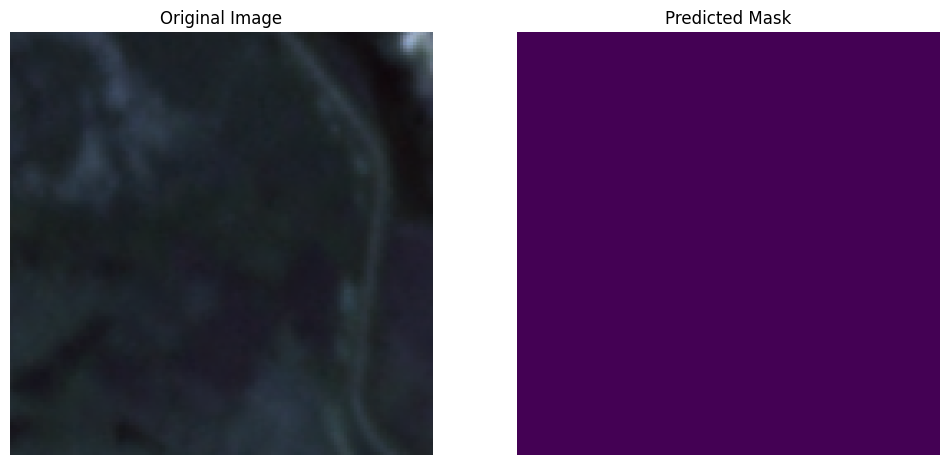

In [104]:
import matplotlib.pyplot as plt

def visualize_prediction(original_image, predicted_mask, figsize=(12, 6)):
    # If the original image has more than 3 channels, select the first three for visualization
    if original_image.shape[-1] > 3:
        original_image = original_image[:, :, :3]

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Display the predicted mask
    # Assuming predicted_mask is 2D (height, width), you might want to add a colormap
    axes[1].imshow(predicted_mask, cmap='viridis')  # Use a colormap that suits your task
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')
    plt.show()

prediction = model.predict(image)

# Convert prediction to a class mask
predicted_mask = np.argmax(prediction, axis=-1)[0, :, :]  # Remove batch dimension
adjusted_image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
visualize_prediction(adjusted_image[0], predicted_mask)


In [ ]:
# model = load_model('/content/drive/MyDrive/DeepLearning_Project/planet_ThreeYear/test_dataset/model_03222024_1255/model_03222023_1255.h5')

In [54]:
def predict_and_save(model, test_image_dir, model_input_size, output_folder):
    image_files = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir) if f.endswith('.tif')]

    for image_path in image_files:
        with rasterio.open(image_path) as src:
            image = src.read(out_shape=(src.count, model_input_size[0], model_input_size[1]),
                             resampling=rasterio.enums.Resampling.nearest)
            image = np.transpose(image, (1, 2, 0))
            image = np.expand_dims(image, axis=0)  # Add batch dimension
            # image = image / np.max(image)  # Normalize
            image = image / 2555.0

            prediction = model.predict(image)
            prediction_image = np.argmax(prediction, axis=-1)[0, :, :]
            meta = src.meta
            # meta.update(dtype=rasterio.uint8, count=1)
            meta.update(dtype=rasterio.uint8, count=1, nodata=None)



            output_path = os.path.join(output_folder, f"prediction_{os.path.basename(image_path)}")
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(prediction_image.astype(rasterio.uint8), 1)

In [ ]:
# Define model input size and paths
IMG_HEIGHT, IMG_WIDTH = img_height, img_width  # Ensure these are defined or replace them with actual values
test_image_dir = '/content/drive/MyDrive/data/working_dir_3year/hold_images/'
output_folder = '/content/drive/MyDrive/data/working_dir_3year/model_3year_20240415_1835/'

# /content/drive/MyDrive/DeepLearning_Project/planet_TwoYear/test_dataset/model_03222024_1255/model_03222024_1255.h5

# Make sure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Execute prediction and saving
predict_and_save(model, test_image_dir, (IMG_HEIGHT, IMG_WIDTH), output_folder)
